<a href="https://colab.research.google.com/github/ashutoshsinha25/pepcoding_FJP_DS/blob/main/Conceate%20Crack%20Detection/FJP_DS_Crack_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn 
import torch.optim as optim 

from torch.utils.data import DataLoader , sampler 
from torch.optim import lr_scheduler
from torchvision import datasets , models , transforms 

import torchvision 
import numpy as np 

import os 
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


cwd = os.getcwd()
from PIL import Image

Link to the cracks data set: https://data.mendeley.com/datasets/5y9wdsg2zt/2

In [1]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2022-11-17 16:21:51--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.109.248, 52.218.89.152, 52.218.106.72, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.109.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  22.6MB/s    in 11s     

2022-11-17 16:22:02 (21.4 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [16]:
!unzip '/content/5y9wdsg2zt-2.zip'

Archive:  /content/5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [20]:
!ls

5y9wdsg2zt-2.zip  Concrete_Crack_Images_for_Classification.rar	sample_data


In [21]:
# !unzip '/content/Concrete_Crack_Images_for_Classification.rar'

In [23]:
!pip install unrar
!unrar x /content/Concrete_Crack_Images_for_Classification.rar

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [26]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  20000


In [27]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  20000


*****************Random Images with Cracks**************************


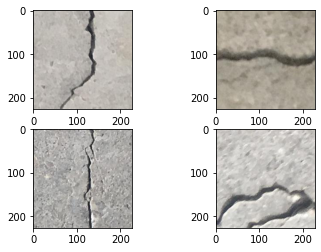

In [28]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

*****************Random Images without Cracks**************************


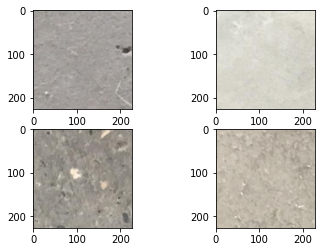

In [29]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

# Create train and val datasets

In [30]:
# Create training folder

base_dir = cwd
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

In [31]:
create_training_data('Positive')
create_training_data('Negative')

In [32]:
# Move images randomly from training to val folders

os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [33]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [34]:

print(len(positive_files), len(negative_files))

20000 20000


In [35]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

In [36]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

# Pytorch data loader and transforms

In [38]:
# Compute mean and std deviation for the dataset

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [39]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [40]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [41]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  31998
Class Names are:  ['Negative', 'Positive']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 3, 227, 227]) torch.Size([8])


In [43]:
# Visualize the Augmented Data Set

# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

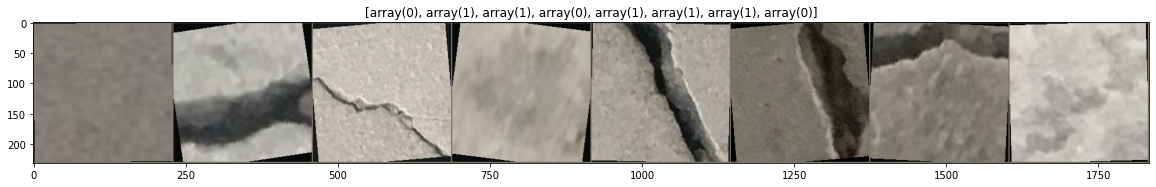

In [44]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [45]:
# Set up Pretrained Model

## Load pretrained model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [46]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [47]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

In [48]:
# Start training


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [49]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2835 Acc: 0.8855
Iterating through data...
val Loss: 0.1494 Acc: 0.9520

Epoch 1/5
----------
Iterating through data...
train Loss: 0.1834 Acc: 0.9320
Iterating through data...
val Loss: 0.0632 Acc: 0.9800

Epoch 2/5
----------
Iterating through data...
train Loss: 0.1648 Acc: 0.9378
Iterating through data...
val Loss: 0.0540 Acc: 0.9829

Epoch 3/5
----------
Iterating through data...
train Loss: 0.1603 Acc: 0.9391
Iterating through data...
val Loss: 0.0562 Acc: 0.9809

Epoch 4/5
----------
Iterating through data...
train Loss: 0.1619 Acc: 0.9375
Iterating through data...
val Loss: 0.0478 Acc: 0.9844

Epoch 5/5
----------
Iterating through data...
train Loss: 0.1535 Acc: 0.9424
Iterating through data...
val Loss: 0.0503 Acc: 0.9833

Training complete in 18m 6s
Best val Acc: 0.984379


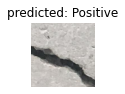

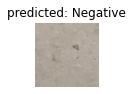

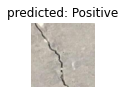

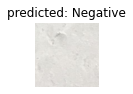

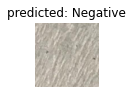

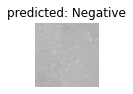

In [50]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

In [51]:
# Inference


def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [52]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

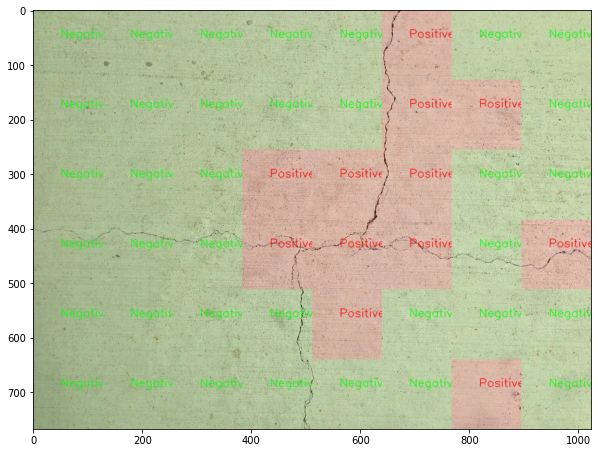

In [60]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('concrete_crack1.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

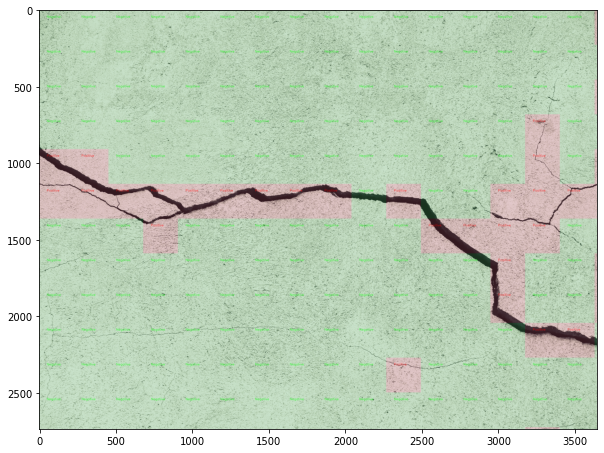

In [64]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('concrete_crack2.jpg')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

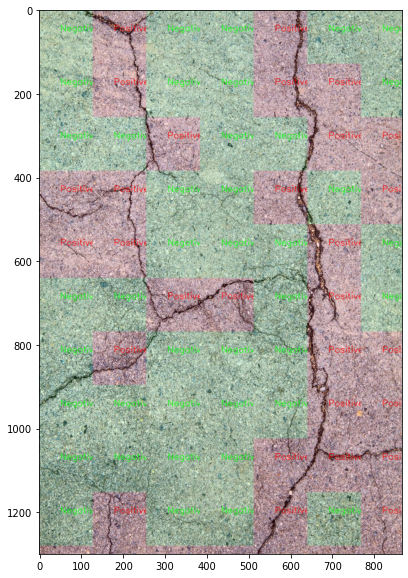

In [61]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('road_surface_crack1.jpg', 128,128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

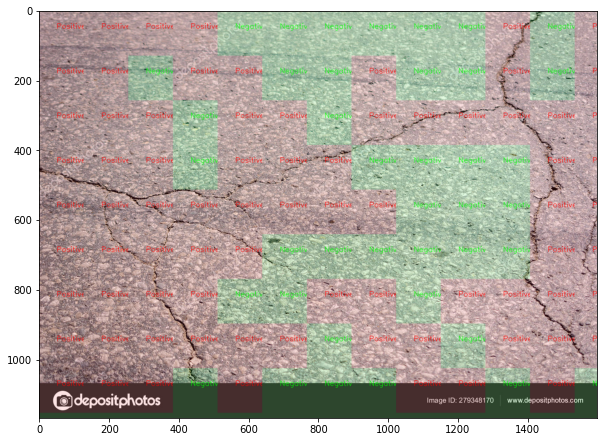

In [62]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('road_surface_crack3.jpg',128,128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))